In [2]:
import os
import json
import random
import pickle
import math
from pathlib import Path
from utils import Tokenizer, Embedding
from torch.nn.utils import clip_grad_norm
from dataset import Seq2SeqDataset
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [3]:
with open("../datasets/seq2seq/train.pkl", "rb") as f:
    training = pickle.load(f)
with open("../datasets/seq2seq/valid.pkl", "rb") as f:
    valid = pickle.load(f)
with open("../datasets/seq2seq/embedding.pkl", "rb") as f:
    embedding = pickle.load(f)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cuda
1.0.0


In [5]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [20]:
import math
import torch
import random
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F



class Encoder(nn.Module):
    def __init__(self, input_size, embedding, hidden_size,
                 n_layers=1, dropout=0.5):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
#         self.embed_size = embed_size
        emb = nn.Embedding(input_size, hidden_size)
        emb.weight.data.copy_(embedding.vectors)
        self.embed = emb
        self.gru = nn.GRU(embed_size, hidden_size, n_layers,
                          dropout=dropout, bidirectional=True)

    def forward(self, src, hidden=None):
        embedded = self.embed(src)
        outputs, hidden = self.gru(embedded, hidden)
        # sum bidirectional outputs
        outputs = (outputs[:, :, :self.hidden_size] +
                   outputs[:, :, self.hidden_size:])
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]


class Decoder(nn.Module):
    def __init__(self, embedding, hidden_size, output_size,
                 n_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        emb = nn.Embedding(output_size, hidden_size)
        emb.weight.data.copy_(embedding.vectors)
        self.embed = emb
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.attention = Attention(hidden_size)
        self.gru = nn.GRU(hidden_size + embed_size, hidden_size,
                          n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input, last_hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
        embedded = self.embed(input).unsqueeze(0)  # (1,B,N)
        embedded = self.dropout(embedded)
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attention(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
        context = context.transpose(0, 1)  # (1,B,N)
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat([embedded, context], 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        output = output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        output = self.out(torch.cat([output, context], 1))
        output = F.log_softmax(output, dim=1)
        return output, hidden, attn_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(1)
        max_len = trg.size(0)
        vocab_size = self.decoder.output_size
        outputs = Variable(torch.zeros(max_len, batch_size, vocab_size)).cuda()

        encoder_output, hidden = self.encoder(src)
        hidden = hidden[:self.decoder.n_layers]
        output = Variable(trg.data[0, :])  # sos
        for t in range(1, max_len):
            output, hidden, attn_weights = self.decoder(
                    output, hidden, encoder_output)
            outputs[t] = output
            is_teacher = random.random() < teacher_forcing_ratio
            top1 = output.data.max(1)[1]
            output = Variable(trg.data[t] if is_teacher else top1).cuda()
        return outputs
    
def val_eval(model, val_iter, vocab_size):
#     model.eval()
    pad = 0
    total_loss = 0
    breaker = len(val_iter)
    with torch.no_grad():
        for b, batch in enumerate(val_iter):
            src = batch['text'].t().to(device)
            trg = batch['summary'].t().to(device)
            output = model(src, trg, teacher_forcing_ratio=0.0)
            loss = F.nll_loss(output[1:].view(-1, vocab_size),
                                   trg[1:].contiguous().view(-1),
                                   ignore_index=pad)
            total_loss += loss
    return total_loss/breaker

In [10]:
grad_clip = 50
en_size = len(embedding.vocab)
embed_size = 300
hidden_size = 300
batch_size=16
lr=0.0001

In [21]:
teacher_forcing_ratio = 0.5
PAD_token = 0
SOS_token = 1
EOS_token = 2

def train(e, model, optimizer, train_iter, vocab_size, grad_clip):
    model.train()
    total_loss = 0
    pad = 0
    for b, batch in tqdm(enumerate(train_iter)):
        src = batch['text'].t().cuda()
        trg = batch['summary'].t().cuda()
        optimizer.zero_grad()
        output = model(src, trg)
        loss = F.nll_loss(output[1:].view(-1, vocab_size),
                               trg[1:].contiguous().view(-1),
                               ignore_index=pad)
        loss.backward()
        clip_grad_norm(model.parameters(), grad_clip)
        optimizer.step()
#         print(loss)
        total_loss += loss

        if b % 1000 == 0 and b != 0:
            total_loss = total_loss / 1000
            print("[%d][loss:%5.2f][pp:%5.2f]" %
                  (b, total_loss, math.exp(total_loss)))
            total_loss = 0
        
    return total_loss / len(train_iter)

In [12]:
encoder = Encoder(en_size, embedding, hidden_size,
                  n_layers=2, dropout=0.2)
decoder = Decoder(embedding, hidden_size, en_size,
                  n_layers=1, dropout=0.2)
seq2seq = Seq2Seq(encoder, decoder).cuda()

optimizer = optim.Adam(seq2seq.parameters(), lr)
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embed): Embedding(97513, 300)
    (gru): GRU(300, 300, num_layers=2, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(97513, 300)
    (dropout): Dropout(p=0.2, inplace)
    (attention): Attention(
      (attn): Linear(in_features=600, out_features=300, bias=True)
    )
    (gru): GRU(600, 300, dropout=0.2)
    (out): Linear(in_features=600, out_features=97513, bias=True)
  )
)


/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
1001it [07:34,  1.94it/s]

[1000][loss: 3.36][pp:28.69]


2001it [15:15,  1.89it/s]

[2000][loss: 3.34][pp:28.13]


3001it [22:52,  1.76it/s]

[3000][loss: 3.30][pp:27.12]


4001it [30:28,  1.91it/s]

[4000][loss: 3.30][pp:27.10]


4476it [34:05,  2.19it/s]


[Epoch:0] val_loss:6.383 | val_pp:591.55S
[!] saving model...


<Figure size 432x288 with 0 Axes>

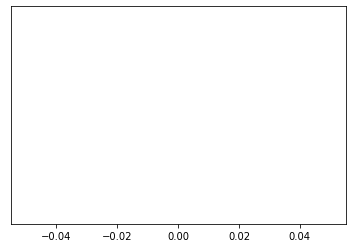

1001it [07:35,  1.89it/s]

[1000][loss: 3.16][pp:23.49]


2001it [15:09,  1.79it/s]

[2000][loss: 3.16][pp:23.63]


3001it [22:44,  1.94it/s]

[3000][loss: 3.17][pp:23.92]


4001it [30:25,  1.83it/s]

[4000][loss: 3.17][pp:23.82]


4476it [34:01,  2.19it/s]


[Epoch:1] val_loss:6.392 | val_pp:596.83S


<Figure size 432x288 with 0 Axes>

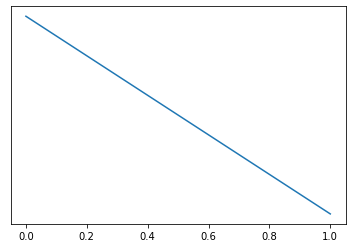

1001it [07:38,  1.70it/s]

[1000][loss: 3.05][pp:21.06]


2001it [15:14,  1.87it/s]

[2000][loss: 3.07][pp:21.54]


3001it [22:53,  1.75it/s]

[3000][loss: 3.05][pp:21.20]


3149it [24:02,  2.20it/s]

KeyboardInterrupt: 

In [40]:
from tqdm import tnrange
val_iter = torch.utils.data.DataLoader(valid, batch_size, shuffle=True,collate_fn=valid.collate_fn)
best_loss = 10000
# iteration = len(train_iter)

print_per = 1000
plot_per = 5000
print_loss = 0
plot_loss = []
for e in tnrange(5):
    train_iter = torch.utils.data.DataLoader(training, batch_size, shuffle=True,collate_fn=training.collate_fn)
    loss = train(e, seq2seq, optimizer, train_iter,
          len(embedding.vocab), grad_clip)
    plot_loss.append(loss.item())
    
    val_loss = val_eval(seq2seq, val_iter, en_size)
    print("[Epoch:%d] val_loss:%5.3f | val_pp:%5.2fS"
              % (e, val_loss, math.exp(val_loss)))
    
    
    if not best_loss or val_loss < best_loss:
        print("[!] saving model...")
        if not os.path.isdir("save"):
            os.makedirs("save")
        torch.save(seq2seq.state_dict(), './save/seq2seq(attention)_%d.pt' % (e))
        best_loss = val_loss
    
    showPlot(plot_loss)

In [15]:
SOS_token = 1
EOS_token = 2

def generate_pair(data):
    pairs = []
    input_length = len(data.data)
    for i in range(input_length):
        input = data.__getitem__(i)['text']
        output = data.__getitem__(i)['summary']
        id = data.__getitem__(i)['id']
        pairs.append((input, output, id))
    return pairs


class Sentence:
    def __init__(self, decoder_hidden, last_idx=SOS_token, sentence_idxes=[], sentence_scores=[]):
        if(len(sentence_idxes) != len(sentence_scores)):
            raise ValueError("length of indexes and scores should be the same")
        self.decoder_hidden = decoder_hidden
        self.last_idx = last_idx
        self.sentence_idxes =  sentence_idxes
        self.sentence_scores = sentence_scores

    def avgScore(self):
        if len(self.sentence_scores) == 0:
            raise ValueError("Calculate average score of sentence, but got no word")
        # return mean of sentence_score
        return sum(self.sentence_scores) / len(self.sentence_scores)

    def addTopk(self, topi, topv, decoder_hidden, beam_size, voc):
        topv = torch.log(topv)
        terminates, sentences = [], []
        for i in range(beam_size):
            if topi[0][i] == EOS_token:
                terminates.append(([voc[idx.item()] for idx in self.sentence_idxes] + ['<EOS>'],
                                   self.avgScore())) # tuple(word_list, score_float
                continue
            idxes = self.sentence_idxes[:] # pass by value
            scores = self.sentence_scores[:] # pass by value
            idxes.append(topi[0][i])
            scores.append(topv[0][i])
            sentences.append(Sentence(decoder_hidden, topi[0][i], idxes, scores))
        return terminates, sentences

    def toWordScore(self, voc):
        words = []
        for i in range(len(self.sentence_idxes)):
            if self.sentence_idxes[i] == EOS_token:
                words.append('<EOS>')
            else:
                words.append(voc[self.sentence_idxes[i].item()])
        if self.sentence_idxes[-1] != EOS_token:
            words.append('<EOS>')
        return (words, self.avgScore())

def decode(decoder, decoder_hidden, encoder_outputs, voc, max_length=40):

    decoder_input = torch.LongTensor([SOS_token])
    decoder_input = decoder_input.to(device)

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length) #TODO: or (MAX_LEN+1, MAX_LEN+1)
#     print(decoder_hidden.size())

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        _, topi = decoder_output.topk(3)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(voc[ni.item()])

        decoder_input = torch.LongTensor([ni])
        decoder_input = decoder_input.to(device)

    return decoded_words, decoder_attentions[:di + 1]


def evaluate(encoder, decoder, voc, sentence , max_length=40):
    indexes_batch = [sentence] #[1, seq_len]
    lengths = [len(indexes) for indexes in indexes_batch]
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    input_batch = input_batch.to(device)
    batch_size = input_batch.size(1)
    encoder_outputs, encoder_hidden = encoder(input_batch, None)

    decoder_hidden = encoder_hidden.view(encoder.n_layers, batch_size, -1)
    return decode(decoder, decoder_hidden, encoder_outputs, voc)


def evaluateRandomly(encoder, decoder, tokenizer, voc, pairs, reverse, beam_size, n=10):
    for _ in range(n):
        pair = random.choice(pairs)
        print("=============================================================")
        if reverse:
            print('>', " ".join(reversed(pair[0].split())))
        else:
            print('>', tokenizer.decode(pair[0]))
            print('=', tokenizer.decode(pair[1]))
        if beam_size == 1:
            output_words, _ = evaluate(encoder, decoder, voc, pair[0], beam_size)
            output_sentence = ' '.join(output_words)
            print('<', output_sentence)
        else:
            output_words_list = evaluate(encoder, decoder, voc, pair[0], beam_size)
            for output_words, score in output_words_list:
                output_sentence = ' '.join(output_words)
                print("{:.3f} < {}".format(score, output_sentence))
                
def predict_out(list_dict, file_path):
    with open(file_path , 'w') as outfile:
        for entry in list_dict:
            json.dump(entry, outfile)
            outfile.write('\n')
            
def predict(encoder, decoder, voc, pairs):
    n = len(pairs)
    out = []
    show_per = 4000
    for i in tnrange(n):
        predict = {}
        pair = pairs[i]
        output_words, attention = evaluate(encoder, decoder, voc, pair[0])
        output_sentence = ' '.join(output_words)
        if(i % show_per == 0):
            print('>', tokenizer.decode(pair[0]))
            print('<', output_sentence[:-6])
#             show_attention(tokenizer.decode(pair[0]), output_sentence, attention)
        predict['id'] = pair[2]
        predict['predict'] = output_sentence[:-6]
        out.append(predict)
    return out

IndentationError: unexpected indent (<ipython-input-15-1c71fc756540>, line 17)

In [42]:
tokenizer = Tokenizer(embedding.vocab, lower=False)
pairs = generate_pair(valid)
evaluateRandomly(encoder, decoder, tokenizer, embedding.vocab, pairs, False, 1, 2)

> its food and agriculture organization ( fao ) saw monthly falls in all major commodities , from milk and vegetables to oils , sugar and cereals . <unk> food producers are being hit by slowing demand in china and a russian embargo on western products . <unk> now the european commission is to release € 500 m ( $ 557 m ) to help europe 's farmers . <unk> the commission said the most significant part of the package would support the dairy sector in all eu member states . <unk> dairy farmers have suffered a 20 % fall in european wholesale milk prices in the past year . <unk> the european commission aid comes on top of extra help for european fruit and vegetable farmers , who have been hit by the russian embargo on western food imports in retaliation for eu and us sanctions over the crisis in ukraine . <unk> farmers across europe have been protesting in recent weeks against the plunging prices that they say are destroying their businesses . <unk> on monday , belgian police fired tear gas a

In [44]:
if not os.path.isdir("save"):
    os.makedirs("save")
# torch.save(seq2seq.state_dict(), './save/seq2seq(attention)_final.pt')

In [97]:
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)))

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticklabels(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

Setting up a new session...
Traceback (most recent call last):
  File "/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/urllib3/connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/urllib3/util/connection.py", line 84, in create_connection
    raise err
  File "/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/urllib3/util/connection.py", line 74, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/urllib3/connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/urllib3/connectionpool.py", line 387, in _make_request
    conn.request(method, url, **httplib_request_k

Exception in user code:
------------------------------------------------------------


In [43]:
import json
tokenizer = Tokenizer(embedding.vocab, lower=False)

def predict_out(list_dict, file_path):
    with open(file_path , 'w') as outfile:
        for entry in list_dict:
            json.dump(entry, outfile)
            outfile.write('\n')
            
def predict(encoder, decoder, voc, pairs):
    n = len(pairs)
    out = []
    show_per = 1000
    for i in tnrange(n):
        predict = {}
        pair = pairs[i]
        output_words, attention = evaluate(encoder, decoder, voc, pair[0])
        output_sentence = ' '.join(output_words)
        if(i % show_per == 0):
            print('================================')
            print('>', tokenizer.decode(pair[0]))
            print('<', output_sentence[:-6])
#             show_attention(tokenizer.decode(pair[0]), output_sentence, attention)
        predict['id'] = pair[2]
        predict['predict'] = output_sentence[:-6]
        out.append(predict)
    return out

pairs = generate_pair(valid)
out = predict(encoder, decoder, embedding.vocab, pairs)
predict_out(out, "../data/attention_output.jsonl")

/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


> the building was to be pulled down as part of a redevelopment of the lawn complex in lincoln . <unk> bosses at woodside wildlife park have now stepped in to save it and will move it to their site near <unk> . <unk> it will be used as an attraction housing exotic animals and coral reef aquariums . <unk> the conservatory is named after the lincolnshire botanist who travelled with captain james cook on his first voyage to the south pacific in 1768 . <unk> the grade ii listed lawn complex was sold by city of lincoln council last year to the stokes coffee company which plans to open a cafe and museum on the site . <unk> neil <unk> , director of the wildlife park , said he wanted to save the building , which housed exotic plants and koi carp and was popular with generations of families . <unk> " i , like a lot of people , spent my younger days coming here and bringing my children here , " he said . <unk> " when i heard that it was being demolished and closing down , i thought we were proba

> orient are in the league two relegation zone having won one of their last nine games and some fans have called for president francesco <unk> to quit . <unk> but collins told bbc radio london : " it certainly does n't seem like a place that 's down . training has been positive and the lads have been positive . " <unk> collins , 30 , made his debut in saturday 's 2 - 0 home defeat by crewe . <unk> he joined the o 's on a three - month contract last week , having been a free agent since leaving indian side bengaluru earlier this year . <unk> and the former huddersfield , scunthorpe and york midfielder believes his new side can climb away from danger . <unk> " there have been some disappointing results but i do n't think it would take much to turn it around , " he said . <unk> " i 've been in sides before where you know there are problems and i do n't sense that here . sometimes in football you just need a bit of luck and over the coming weeks hopefully we 'll get that . <unk> " nobody i

> herve <unk> was on trial for leaking bank data that led to tax evasion probes worldwide against prominent clients with accounts in switzerland . <unk> <unk> did not attend the trial and because france does not extradite its own citizens , it is unlikely he will serve the sentence . <unk> he told ap news agency he had " no reaction " to the sentencing . <unk> <unk> had refused to travel from france to appear before the swiss federal tribunal in <unk> for a trial that began last month . <unk> he was charged with illegally obtaining data , economic espionage , breach of business confidentiality and breach of bank secrecy while working at a swiss hsbc subsidiary between 2006 and 2008 . <unk> the court rejected all the charges except for one alleging a violation of economic intelligence , for having made public information about foreign entities in lebanon , france , germany , and the uk . <unk> hsbc , which argued that he had illegally downloaded details from clients and accounts , welco

In [39]:
# encoder = Encoder(en_size, embedding, hidden_size,
#                   n_layers=2, dropout=0.2)
# decoder = Decoder(embedding, hidden_size, en_size,
#                   n_layers=1, dropout=0.2)
model = Seq2Seq(encoder, decoder).cuda()
model.load_state_dict(torch.load('./save/seq2seq_10002.pt'))
out = predict(model.encoder, model.decoder, embedding.vocab, pairs)
predict_out(out, "../data/attention_output.jsonl")

/home/littleemma/ImageDB/imagedb/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


> the building was to be pulled down as part of a redevelopment of the lawn complex in lincoln . <unk> bosses at woodside wildlife park have now stepped in to save it and will move it to their site near <unk> . <unk> it will be used as an attraction housing exotic animals and coral reef aquariums . <unk> the conservatory is named after the lincolnshire botanist who travelled with captain james cook on his first voyage to the south pacific in 1768 . <unk> the grade ii listed lawn complex was sold by city of lincoln council last year to the stokes coffee company which plans to open a cafe and museum on the site . <unk> neil <unk> , director of the wildlife park , said he wanted to save the building , which housed exotic plants and koi carp and was popular with generations of families . <unk> " i , like a lot of people , spent my younger days coming here and bringing my children here , " he said . <unk> " when i heard that it was being demolished and closing down , i thought we were proba

> orient are in the league two relegation zone having won one of their last nine games and some fans have called for president francesco <unk> to quit . <unk> but collins told bbc radio london : " it certainly does n't seem like a place that 's down . training has been positive and the lads have been positive . " <unk> collins , 30 , made his debut in saturday 's 2 - 0 home defeat by crewe . <unk> he joined the o 's on a three - month contract last week , having been a free agent since leaving indian side bengaluru earlier this year . <unk> and the former huddersfield , scunthorpe and york midfielder believes his new side can climb away from danger . <unk> " there have been some disappointing results but i do n't think it would take much to turn it around , " he said . <unk> " i 've been in sides before where you know there are problems and i do n't sense that here . sometimes in football you just need a bit of luck and over the coming weeks hopefully we 'll get that . <unk> " nobody i

> herve <unk> was on trial for leaking bank data that led to tax evasion probes worldwide against prominent clients with accounts in switzerland . <unk> <unk> did not attend the trial and because france does not extradite its own citizens , it is unlikely he will serve the sentence . <unk> he told ap news agency he had " no reaction " to the sentencing . <unk> <unk> had refused to travel from france to appear before the swiss federal tribunal in <unk> for a trial that began last month . <unk> he was charged with illegally obtaining data , economic espionage , breach of business confidentiality and breach of bank secrecy while working at a swiss hsbc subsidiary between 2006 and 2008 . <unk> the court rejected all the charges except for one alleging a violation of economic intelligence , for having made public information about foreign entities in lebanon , france , germany , and the uk . <unk> hsbc , which argued that he had illegally downloaded details from clients and accounts , welco